<img src="imdb6.jpg">

<center>    
# Предсказание тональности отзывов к фильмам портала IMDB

<center>
**Поляков Евгений**

## Аннотация

Предсказание тональности текста - полезная функциональность, которая может быть применена в различных областях. Например при оценивани коментариев к новостям об определенном персонаже или известной личности. Наиболее полезным может служить для политических лидеров, и в режиме реального времени по отзывам к новосям в социальных сетях, можно строить картину удовлетворенности пользователей работе... (че-то надо покрасивше придумать)

В данной работе оценка тональности текста проводиться на основе рецензий к фильмам собранных с сайта IMDB... (тоже классно придумать описание)

## Содержание

1. Подготовка среды
2. Описание набора данных и признаков
3. Первичный анализ даных
4. Первичный визуальный анализ данных
5. Инсайты, найденные зависимости
6. Выбор метрики
7. Выбор модели
8. Предобработка данных
9. Кросс-валидация и настройка гиперпараметров модели
10. Создание новых признаков и описание этого процесса
11. Построение кривых валидации и обучения
12. Прогноз для тестовой или отложенной выборки
13. Выводы

## 1. Подготовка среды

**Подкдючения библиотек и скриптов**

In [219]:
# Экстеншен для обновления кода во внешних файлах
%load_ext autoreload
%autoreload 2

# Подключаем пути для скриптов
import sys
sys.path.insert(0, 'scripts/data')

# Обработка данных
import data_hlp

import pixiedust
import keras
from keras import preprocessing

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from IPython.display import clear_output

import os
import time
import nltk
from nltk.stem import WordNetLemmatizer
from collections import OrderedDict
from py_linq import Enumerable
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Дополнительные данные для исследования**

In [3]:
# английские стоп-слова
nltk.download('stopwords') # Загружаем стоп-слова
en_sw = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\polyakov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Описание набора данных и признаков

Представлен набор данных, который содержит отзывы пользователей на фильмы с портала IMDB. Ссылка на набор данных: http://ai.stanford.edu/~amaas/data/sentiment/


По заявлениям автором набора, он призван служить эталоном для классификации чувств (позитивных или негативных). Набор содержит 50 000 реценизий к фильмам, и поделен на тренировочный и тестовый наборы, по 25 000 в каждом наборе. Каждый из таких наборов поделен на положительные и отрицательные отзывы. Отзывы которые имели нейтральную оценку не были включены в набор. Но были включены те которые выраженно показывают негативное или позитивное отношение к фиильму, что дает возможность более точно предсказывать ситуация избегая неоднозначности.

**Пути к данным**

In [3]:
imdb_dir = 'aclImdb/' # Дериктория с данными
train_dir = imdb_dir + 'train/' # Данные для тренировки
test_dir = imdb_dir + 'test/' # Данные для тестирования
sub_paths = ['pos', 'neg'] # Поддериктории позитивного и негативного класса

**Загрузим тренировочные данные**

In [7]:
%%time
train_data = data_hlp.load_data_set(train_dir, sub_paths)
train_texts, train_lbls = train_data
train_df = pd.DataFrame({'review': train_texts, 'estimate': train_lbls})
clear_output()

Wall time: 4min 48s


**Загрузим тестовые данные**

In [8]:
%%time
test_data = data_hlp.load_data_set(test_dir, sub_paths)
test_texts, test_lbls = test_data
test_df = pd.DataFrame({'review': test_texts, 'estimate': test_lbls})
clear_output()

Wall time: 4min 47s


**Сохраним данные**

In [55]:
data_hlp.save_data(train_df, 'train_df.pickle')
data_hlp.save_data(test_df, 'test_df.pickle')

saving success!
saving success!


Удалим ненужные переменные

In [ ]:
del train_data, train_texts, train_lbls, test_data, test_texts, test_lbls

**<span style="color:red">CHECKPOINT. </span> Загрузим сохраненные данные**

In [225]:
train_df = data_hlp.load_data('train_df.pickle')
test_df = data_hlp.load_data('test_df.pickle')

**Структура данных**

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
estimate    25000 non-null int64
review      25000 non-null object
dtypes: int64(1), object(1)
memory usage: 390.7+ KB


**Посмотрим на распределение классов**

In [9]:
train_df.columns

Index(['estimate', 'review'], dtype='object')

In [10]:
train_df.estimate.value_counts()

1    12500
0    12500
Name: estimate, dtype: int64

In [11]:
test_df.estimate.value_counts()

1    12500
0    12500
Name: estimate, dtype: int64

Данных действительно ровное количество во всех наборах. Это должно положительным образом сказываться на результате.

## 2. Первичный анализ данных

**Посмотрим, как выглядят данные**

In [12]:
display(train_df.sample(7, random_state=10))

estimate,review
0,"Typical thriller, has been done many times before. Simple plot outline; cop Liotta becomes obsessed with Russell's wife, and he tries to bump off good ol' Kurt so he can have her. This is beyond predictable, it doesn't even try to make you guess, the plot is the plot and there's no thinking outside the box here. I guess then the only reason to watch it is to see how it develops, but nothing is done originally or interestingly. There's not really anything to say about this film, it's not particularly bad, but there's no good points either. Russell plays Russell and you know what you're gonna get when you see him in a film. Ditto Liotta. Stowe has an annoying Cher-esque voice. I read the plot outline and I could see the film in my head, it was so obvious and basic. I watched it and it rolled out in front of my eyes exactly as I had imagined. I felt not a drop of emotion throughout. I have no feeling towards this film, it's as if I never even watched it. Considering this, it's a pretty pointless film isn't it? Still, I'll give it 3/10 for some reason."
1,"Before Dogma 95: when Lars used movies as art, not just a story. A beautiful painting about love and death. This is one of my favorite movies of all time. The color... The music... Just perfect."
0,"VAMPYRES Aspect ratio: 1.85:1Sound format: MonoA motorist (Murray Brown) is lured to an isolated country house inhabited by two beautiful young women (Marianne Morris and Anulka) and becomes enmeshed in their free-spirited sexual lifestyle, but his hosts turn out to be vampires with a frenzied lust for human blood...Taking its cue from the lesbian vampire cycle initiated by maverick director Jean Rollin in France, and consolidated by the success of Hammer's ""Carmilla"" series in the UK, Jose Ramon Larraz' daring shocker VAMPYRES pushed the concept of Adult Horror much further than British censors were prepared to tolerate in 1974, and his film was cut by almost three minutes on its original British release. It isn't difficult to see why! Using its Gothic theme as the pretext for as much nudity, sex and bloodshed as the film's short running time will allow, Larraz (who wrote the screenplay under the pseudonym 'D. Daubeney') uses these commercial elements as mere backdrop to a languid meditation on life, death and the impulses - sexual and otherwise - which affirm the human condition.Shot on location at a picturesque country house during the Autumn of 1973, Harry Waxman's haunting cinematography conjures an atmosphere of grim foreboding, in which the desolate countryside - bleak and beautiful in equal measure - seems to foreshadow a whirlwind of impending horror (Larraz pulled a similar trick earlier the same year with SYMPTOMS, a low-key thriller which erupts into a frenzy of violence during the final reel). However, despite its pretensions, VAMPYRES' wafer-thin plot and rough-hewn production values will divide audiences from the outset, and while the two female protagonists are as charismatic and appealing as could be wished, the male lead (Brown, past his prime at the time of filming) is woefully miscast in a role that should have gone to some beautiful twentysomething stud. A must-see item for cult movie fans, an amusing curio for everyone else, VAMPYRES is an acquired taste. Watch out for silent era superstar Bessie Love in a brief cameo at the end of the movie."
1,"Right from the start you see that ""Anchors Aweigh"" is a great comedy. Gene Kelly and Frank Sinatra make such a funny team! The songs they sing together are pure entertainment. Kathryn Grayson is gorgeous and really sweet. Dean Stockwell is the cutiest child actor I've never seen. If you are fond of piano, you'll be amazed by José Iturbi. This movie was the first one to combine animation with real actors and it did that wonderfully in an unforgettable dance number. Undoubtedly one of Kelly's funniest movies."
1,"Dirty Harry has to track down a rape victim who extracts revenge by shooting her assail

**Прмер тестового поля**

Пример положительного отзыва

In [13]:
train_df[train_df['estimate'] == 1]['review'][10][0:300]

'When I first read Armistead Maupins story I was taken in by the human drama displayed by Gabriel No one and those he cares about and loves. That being said, we have now been given the film version of an excellent story and are expected to see past the gloss of Hollywood...<br /><br />Writer Armistea'

Пример отрицательного отзыва

In [14]:
pd.DataFrame(train_df[train_df['estimate'] == 0])['review'][12510][0:300]

"This film is one giant pant load. Paul Schrader is utterly lost in his own bad screenplay. And his directing is about as comatose as it can be without his actually having been sleepwalking during the process. <br /><br />The worst though is Woody Harrelson, whom I ordinarily like when he's properly "

Видно, что в отзывах присутствуют HTML-теги, 
чтобы нормально обучить модель, нужно от них избавиться

Первые два отзыва показали, что отличия в положительных и отрицательных отзывах действительно существенные, если эта тенденция всего набора данных, то возможно более менее преемлемого качества классификации возможно удасться добиться. Проверим эту гипотезу, и выберем несколько выборок из наборов данных, и попробуем проанализировать общие тенденции в данных

**Выберем несколько групп из набора данных, и попробуем выяснить общую тенденцию**

В каждом классе у нас по 12500 рецензий, перемешаем их и выберем по 3 выборки положительных и отрицательных по 1000 наблюдений в каждой выборке

In [15]:
%%time
sub_set_names = ["neg", "pos"]
sub_set_result = {}
itet1_count = 2
iter_2count = 4
for sub_set in range(itet1_count):
    for count_subs in range(1, iter_2count):
        # Информация о выполнении
        print("iter: [{}/{}]-[{}/{}]".format(
            (sub_set + 1), itet1_count, count_subs, iter_2count))
        # Выберем отзывы которые относятся к первому классу, 
        # перемешаем и выберем певые 1000 штук
        tmp_set = train_df[train_df['estimate'] == sub_set].sample(
            frac=1, random_state=18).reset_index(
                drop=True)['review'][1000 * (count_subs - 1):1000 * (count_subs)]
        # Удалим спец-символы и приведем к нижнему решистру
        tmp = data_hlp.clean_symbols_data(tmp_set)
        # Очистим от стоп-слов
        tmp = data_hlp.clean_stop_words(
            tmp, en_sw).copy()
        cur_name = "{}_{}".format(sub_set_names[sub_set], count_subs)
        sub_set_result[cur_name] = tmp
        clear_output()
        # Удалим ненужные переменные
del (tmp_set, cur_name, tmp, sub_set_names, 
    count_subs, sub_set, itet1_count, iter_2count)
clear_output()

Wall time: 7.26 s


**Выберем наиболее часто используемые слова из положительных и отрицательных отзывах**

In [30]:
# Посмотрим на самые популярные слова
most_popular = {}
for key in sub_set_result.keys():
    vcb_pop, _ = data_hlp.create_vocab(sub_set_result[key])
    val = Enumerable(vcb_pop).take(15).to_list()
    most_popular[key] = val
    clear_output(wait=True)
del key, val, vcb_pop, _
display(pd.DataFrame(most_popular))

neg_1,neg_2,neg_3,pos_1,pos_2,pos_3
movie,movie,movie,movie,film,film
film,film,film,film,movie,movie
one,one,one,one,one,one
like,like,like,like,like,like
good,bad,even,good,good,good
bad,even,bad,story,story,story
even,good,good,well,great,time
would,would,would,great,see,great
really,really,time,time,well,well
time,time,really,see,time,see


Видно, что наиболее часто используемые слова пересекаются межру 3-мя выборками, и не такого уж и большлго размера. Отсюда можно сделать вывод, что данные являются репрезентативными на таком небольшой обьеме выборки, и можно достаточно плодотворно проводить исседование именно на такой подвыборке,  и не задействовать все данные из всего дата-сета. Но есть небольшое замечание, что популярные слова встречаются как в положительной так и в отрицательных рецензиях. Нужно проверить на достоверность рецензий, вполне возможно, что есть негативные рецензии, которые помечены как позитивные и наоборот. Это может сыграть злую шутку в классификации.

## Первичный визуальный анализ данных

Посмотрим как соотноситься длина отзывов когда они положительные и отрицательные

Выберем 3000 случайных отзывов, и на них будем строить предположения

In [227]:
sub_set = train_df.sample(frac=1)[0: 3000]

In [233]:
pos_counts = sub_set[sub_set['estimate'] == 1]['review'].apply(lambda x: len(x.split()))
neg_counts = sub_set[sub_set['estimate'] == 0]['review'].apply(lambda x: len(x.split()))

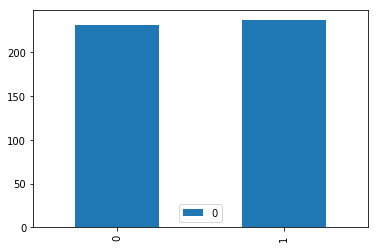

In [239]:
ax = pd.DataFrame([np.mean(neg_counts), np.mean(pos_counts)]).plot.bar()

Тут будет много граыыиков и исследований... только позже...

## Предобработка данных

**Первичная предобработка**

Видно было, что в данных есть мусор, есть html_теги, для начала было бы неплохо от этого избавиться, а также сразу удалим стоп-слова

**Очистим данные от ''мусора''**

In [3]:
%%time
print("iter: 1/2")
train_df['review'] = data_hlp.clean_symbols_data(train_df['review'])
clear_output()
print("iter: 2/2")
test_df['review'] = data_hlp.clean_symbols_data(test_df['review'])
clear_output()

Wall time: 33.8 s


**Удалим стоп-слова**

In [6]:
%%time
print("iter: 1/2")
train_df['review'] = data_hlp.clean_stop_words(train_df['review'], en_sw)
clear_output()
print("iter: 2/2")
test_df['review'] = data_hlp.clean_stop_words(test_df['review'], en_sw)
clear_output()

Wall time: 39.9 s


**Сохраним данные**

In [9]:
data_hlp.save_data(train_df, 'train_df_cleaned.pickle')
data_hlp.save_data(test_df, 'test_df_cleaned.pickle')

saving success!
saving success!


**<span style="color:red">CHECKPOINT. </span> Загрузим сохраненные данные**

In [4]:
train_df = data_hlp.load_data('train_df_cleaned.pickle')
test_df = data_hlp.load_data('test_df_cleaned.pickle')

Вот так теперь все это выглядит без стоп-слов

In [33]:
train_df['review'][1][1:200]

'omelessness houselessness george carlin stated issue years never plan help street considered human everything going school work vote matter people think homeless lost cause worrying things racism war'

**Создание словаря**

In [34]:
%%time
train_df_vocab_by_count, train_df_vocab_by_popular = data_hlp.create_vocab(train_df['review'])
clear_output()

Wall time: 1.44 s


Длина словаря

In [36]:
len(train_df_vocab_by_popular)

74065

In [ ]:
Посмотрим как выглядит список самых популярных слов

In [58]:
print(pd.DataFrame({"Word Name": Enumerable({v:k for k,v in train_df_vocab_by_count.items()}).take(15).to_list(),
"Count": Enumerable(train_df_vocab_by_count).take(15).to_list()}))

     Count  Word Name
0    movie      44031
1     film      40147
2      one      26788
3     like      20274
4     good      15140
5     time      12724
6     even      12646
7    would      12436
8    story      11983
9   really      11736
10     see      11475
11    well      10662
12    much       9765
13     get       9310
14     bad       9301


Как и в случае выборок по 1000 значений, слова: ***movie*** и ***film***  оказались самыми популярными

**Создание векторного представления**

Для примера возьмем 10000 слов в словаре, но при обучении модели попробуем найти оптимальные параметры количества свлов в словаре при подборе параметров

In [199]:
#time
print("iter: 1/2")
train_df['review_vec'] = data_hlp.create_vectors(train_df['review'], train_df_vocab_by_popular, 10000)
clear_output()
print("iter: 1/2")
test_df['review_vec'] = data_hlp.create_vectors(test_df['review'], train_df_vocab_by_popular, 10000)
clear_output()

Получили вот такие векторые представления

In [200]:
display(train_df[['review', 'review_vec']])

review,review_vec
keeps us going least feel writer wanted us keep us glued early point desire know whether martinaud done dirty deed without spoiling much course red herring twist discover story martinaud imperfections difficulty coping revelation begin sympathize pity story progresses made think sick perverted pedophiliac predisposed mind one things cope distant gap wife even though live roof problems course given denouement film shocking finale movie demands patience certainly tried restless teenagers sitting rear heckling obviously partial central location films although bit travelling get woods beach realize gallien clever made think inquisitor,"[786, 76, 70, 112, 122, 408, 341, 76, 276, 76, 6175, 273, 104, 1594, 41, 581, 9999, 113, 1470, 6781, 99, 7455, 13, 146, 606, 9999, 845, 1805, 9, 9999, 9999, 5442, 9999, 3227, 741, 5334, 2069, 9, 4439, 20, 25, 1026, 7445, 9999, 9999, 210, 3, 79, 5389, 3415, 6939, 195, 7, 55, 286, 5111, 567, 146, 228, 6979, 2, 1450, 1799, 1, 3721, 4902, 308, 652, 9049, 2163, 1107, 5795, 9999, 405, 9283, 1204, 1455, 30, 144, 116, 9235, 14, 1245, 2407, 773, 9999, 936, 20, 25, 9999]"
saw legacy theater joseph smith memorial building salt lake city morning going assume one level enjoyment movie largely based one level acceptance joseph story however aside well made well acted nice score get salt lake city must see legacy theater never nicer theater far picture quality sound quality ambiance entire life wonder church would let watch batman begins lds regard joseph prophet touched several places brought tears quite times presume expected since handed tissues movie started anyway told film available several lds visitor centers around globe minutes check whether believe joseph smith tells fascinating story,"[109, 4916, 602, 2053, 1010, 9999, 1264, 5600, 1915, 396, 1807, 70, 2079, 3, 507, 2955, 1, 2089, 321, 3, 507, 5391, 2053, 9, 86, 1055, 12, 20, 12, 765, 207, 463, 14, 5600, 1915, 396, 100, 11, 4916, 602, 36, 9999, 602, 119, 304, 357, 349, 357, 7737, 309, 33, 455, 1227, 8, 164, 28, 1153, 630, 8644, 2726, 2053, 8645, 2668, 324, 1203, 689, 1511, 77, 103, 8218, 722, 126, 2529, 9999, 1, 508, 418, 442, 2, 1282, 324, 8644, 7238, 4432, 83, 5550, 121, 667, 581, 147, 2053, 1010, 570, 1278, 9]"
really wanted like movie nice prison setting conspiracy theories bloodthirsty zombies perfectly hideous touch directorial effort actor john saxon also plays bad guessed bad guy reminds beloved italian horror flicks direction wooden nightmarish frightening moment goes logically end suspense daring visuals destiny cult classic would sealed,"[10, 341, 4, 1, 207, 1011, 800, 3385, 6390, 9999, 964, 795, 4031, 1058, 3506, 634, 157, 182, 9999, 17, 181, 15, 4154, 15, 117, 1633, 2570, 949, 84, 1380, 333, 1483, 7116, 2361, 420, 153, 9999, 45, 687, 3697, 1894, 3969, 1036, 232, 8, 9520]"
lucky enough watch without pre viewing hype surprised resilience ghost image mind next day day watched times time appreciate even settings gorgeous town dusk beautiful lighting effects marsh long shots house sufficiently grown moss main hero likable good natured easily sympathized person complained enough spark film say whole fight ghost waged one person fairly slow paced film unusual amount time spent pre post ghost attack developing character family work life spoilers discussion especially liked turning point comes back main town meets man helping explains seeing ghost describes woman black end conversation says going back harm done man says go back alone lends hero dog cute little dog offers small respite comic relief bounding house even locked room many casual appearances ghost really freaked woman shows mid shot church showing afraid church also shy bound house beginning another unbelievably memorable scene kids outside church fence watching funeral camera pans right woman seen background among gravestones older man even look kids yelling taunting crreeepy usually ghosts hidden shadows haunting specific locales people mentioned ghost malevolence wrath

Протестим, правильно ли конвертировалаось в вектора

In [201]:
# Перевернем словарь, чтобы удобнее доставть слова по числам
flipped_train_df_vocab = {v:k for k,v in train_df_vocab_by_popular.items()}
sentence = []
for vec in train_df['review_vec'][0]:
    sentence.append(flipped_train_df_vocab[vec])
sentence = ' '.join(sentence)
display(pd.DataFrame({'Original Text': [sentence], "Text From Vector": [train_df['review'][0]]}))

Original Text,Text From Vector
sheeta high cartoon comedy ran time programs school life teachers years teaching profession lead believe sheeta high satire much closer reality teachers sheeta survive sheeta insightful students see right pathetic teachers sheeta sheeta whole situation remind schools knew students saw episode student repeatedly tried burn school immediately sheeta high classic line inspector sack one teachers student welcome sheeta high expect many adults age think sheeta high far fetched pity,bromwell high cartoon comedy ran time programs school life teachers years teaching profession lead believe bromwell high satire much closer reality teachers scramble survive financially insightful students see right pathetic teachers pomp pettiness whole situation remind schools knew students saw episode student repeatedly tried burn school immediately recalled high classic line inspector sack one teachers student welcome bromwell high expect many adults age think bromwell high far fetched pity


Все сконвертировалось успешно. Первое слово которое оказалось другим, просто не попало в словарь, и заменилось последним словом из словаря. Ну это говорит о том, что есть некоторое количество слов, которое очень редкое и не было извлечено из обучающего набора

## Кросс-валидация и настройка гиперпараметров модели

**Обучим модель на различных парметрах, посмотрим, какую наилучшую модель можно получить**

**mldel_001**

Простая модель

In [618]:
def model_001(max_features, vector_dim, maxlen, x, y, verbose=0):
    callbacks_list = [
                    keras.callbacks.EarlyStopping(
                    monitor='val_acc',
                    patience=1)]
    # Построим первую саму простую модель модель
    model = Sequential()
    model.add(Embedding(max_features, vector_dim, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy',
                        metrics=['acc'])
            # model.summary()
            # Обучаем
    history = model.fit(x, y, epochs=10,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks_list,  
                        verbose=verbose)
    return model, history

In [587]:
def prepare_data_set(train_df, test_df, x_field_name, y_field_name):
    #Перемешаем данные в выборках
    train = train_df.sample(frac=1)
    test = test_df.sample(frac=1)

    # Отделим векторыне представления и метки в разные наборы
    x_train = np.array(train[x_field_name])
    y_train = np.array(train[y_field_name])
    x_test = np.array(test[x_field_name])
    y_test = np.array(test[y_field_name])
    
    return x_train, x_test, y_train, y_test

In [495]:
%%time
# Зафиксируем seed для воспроизводимости результатов
np.random.seed(18)

# Количество слов в словаре. Всего словарь содержит 74065 слов. Попробуем менять длину словаря, и смотреть на результаты

# Лучшие значения для каждого параметра
best_params = {
    'max_features_params': 5000, 'max_vocab': 100, 'output_vector_dimension': 8
}
# Текущее значение параметров
current_param = {
    'max_features_params': 5000, 'max_vocab': 100, 'output_vector_dimension' : 8
}
current_param_names = [
    'max_features_params', 'max_vocab', 'output_vector_dimension'
]
# Обучающая выборка, валидационныая,тестовая выборка, параметры, количество эпох до наступления переобучения
best_log_param = {
    'max_features_params': [[], [], [], [], []],
    'max_vocab' : [[], [], [], [], []],
    'output_vector_dimension' : [[], [], [], [], []]
}

max_features_params = [5000, 10000, 20000, 30000, 40000] # Параметры для перебора количества слов в словаре
max_vocab = [100, 200, 300, 400, 500, 600, 700, 800]
output_vector_dimension = [8, 16, 32, 64, 128, 512]

# Список всех значений параметров
count_params = [
    max_features_params,
    max_vocab,
    output_vector_dimension
]

def teach_network_001():    
    for curr_par in range(len(count_params)): # Проходим по общему набору параметров
        # Инициализируем сначала значения лучшими параметрами
        current_param['max_features_params'] = best_params['max_features_params'] 
        current_param['max_vocab'] = best_params['max_vocab']
        current_param['output_vector_dimension'] = best_params['output_vector_dimension']
        
        print('iter: {}/{}'.format(curr_par + 1, len(count_params)))        
         # Максимальные значения правильности по всем эпохам по каждому значению параметра
        current_best_param_summary = []        
        for param in tqdm_notebook(count_params[curr_par]): # Проходим по конкретному параметру
            
             # Инициализируем текущими параметиами
            if current_param_names[curr_par] == 'max_features_params':               
                current_param[current_param_names[curr_par]] = param
            if current_param_names[curr_par] == 'max_vocab':
                current_param[current_param_names[curr_par]] = param
            if current_param_names[curr_par] == 'output_vector_dimension':
                current_param[current_param_names[curr_par]] = param
            
            
            # Настроим параметры Embedding слоя для векторизации
            max_features = current_param['max_features_params'] # Максимальное количесиво слов словаря
            maxlen = current_param['max_vocab'] # Максимальная длина отзыва
            vector_dim = current_param['output_vector_dimension'] # размерность выходного вектора

            # Создадим вектороное представление            
            #print('create vectors for train')
            train_df['review_vec'] = data_hlp.create_vectors(train_df['review'], train_df_vocab_by_popular, max_features)
            #print('create vectors for test')
            test_df['review_vec'] = data_hlp.create_vectors(test_df['review'], train_df_vocab_by_popular, max_features)
#             clear_output()            
            print("Текущие параметры: ", current_param)
            
            # Подготовка данных
            x_train, x_test, y_train, y_test =  prepare_data_set(train_df, test_df, 'review_vec', 'estimate')

            # Преобразуем последовательность в двумерный тензор с формой (количество образцов, максимальная длина)
            x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen)
            x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen)
            # Параметры прерывания обучения при наступлении переобучения
            
            # Создание и обучение модели
            model, hstory = model_001(max_features, vector_dim, maxlen)
            
            # Сохраняем максимальное по всем эпохам            
            current_best_param_summary.append(max(history.history['val_acc']))
            print("Параметры val_acc: ", current_best_param_summary)
             # Записываем логи параметров для построения графиков (acc на лучшем vall_acc)
            best_log_param[current_param_names[curr_par]][0].append(max(history.history['acc']))
            # (val_acc)
            best_log_param[current_param_names[curr_par]][1].append(max(history.history['val_acc']))
            # Тестовая выборка
            best_log_param[current_param_names[curr_par]][2].append(model.evaluate(x_test, y_test, verbose=0)[1])            
            # Какой параметр при этом использовался
            best_log_param[current_param_names[curr_par]][3].append(param)
            # Количество эпох до наступления переобучения
            best_log_param[current_param_names[curr_par]][4].append(len(history.history['val_acc']))
        
        # Словать сответствий максимальных значений показателя правильности на валидационной выборке и
        # позиции значения в массиве значений параметра
        dct = dict(zip(current_best_param_summary, range(0, len(current_best_param_summary))))
        best_position = dct[max(dct)] # Позиция лучшего параметра
#         print("best: ", count_params[curr_par][best_position])
        
        # Сохраняем лучший парамет        
        if current_param_names[curr_par] == 'max_features_params':      
            best_params[current_param_names[curr_par]] = count_params[curr_par][best_position]
        if current_param_names[curr_par] == 'max_vocab':
            best_params[current_param_names[curr_par]] = count_params[curr_par][best_position]
        if current_param_names[curr_par] == 'output_vector_dimension':
            best_params[current_param_names[curr_par]] = count_params[curr_par][best_position]            
            
        print("Лог параметров: ", best_log_param)
        print("Лучшие параметры: ", best_params)
        #clear_output()

Wall time: 0 ns


Обучим самую простоую нейронную сеть, с перебором параметров. Полный перебор делать не будем, в виду экономии времени. Будм перебирать и настраивать по 1 параметру. Т.е., сначала будем менять размер словаря, выберем лучший, потом размер самого отзыва и тоже выберем лучший, а потом размер выходного вектора

In [496]:
%%time
teach_network_001()

iter: 1/3


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

Текущие параметры:  {'max_features_params': 5000, 'max_vocab': 100, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8784]
Текущие параметры:  {'max_features_params': 10000, 'max_vocab': 100, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8784, 0.8798]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 100, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8784, 0.8798, 0.8888]
Текущие параметры:  {'max_features_params': 30000, 'max_vocab': 100, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8784, 0.8798, 0.8888, 0.8848]
Текущие параметры:  {'max_features_params': 40000, 'max_vocab': 100, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8784, 0.8798, 0.8888, 0.8848, 0.8852]

Лог параметров:  {'max_features_params': [[0.9203, 0.92885, 0.94075, 0.93435, 0.94825], [0.8784, 0.8798, 0.8888, 0.8848, 0.8852], [0.86688, 0.87256, 0.87172, 0.87364, 0.86996], [5000, 10000, 20000, 30000, 40000], [5, 5, 5, 4, 6]], 'max_vocab': [[], [], [], [], []], 'output_vector

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 100, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8882]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 200, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8882, 0.8976]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 300, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8882, 0.8976, 0.8968]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 400, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8882, 0.8976, 0.8968, 0.8966]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 500, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8882, 0.8976, 0.8968, 0.8966, 0.8968]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 600, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8882, 0.8976, 0.8968, 0.8966, 0.8968, 0.8934]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 700, 'output_vector_dimension': 8}
Параметры val

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 200, 'output_vector_dimension': 8}
Параметры val_acc:  [0.8894]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 200, 'output_vector_dimension': 16}
Параметры val_acc:  [0.8894, 0.8878]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 200, 'output_vector_dimension': 32}
Параметры val_acc:  [0.8894, 0.8878, 0.8884]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 200, 'output_vector_dimension': 64}
Параметры val_acc:  [0.8894, 0.8878, 0.8884, 0.8964]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 200, 'output_vector_dimension': 128}
Параметры val_acc:  [0.8894, 0.8878, 0.8884, 0.8964, 0.8898]
Текущие параметры:  {'max_features_params': 20000, 'max_vocab': 200, 'output_vector_dimension': 512}
Параметры val_acc:  [0.8894, 0.8878, 0.8884, 0.8964, 0.8898, 0.875]

Лог параметров:  {'max_features_params': [[0.9203, 0.92885, 0.94075, 0.93435, 0.94825], [0.8784, 0.8798, 

Посмотрим на изменение правильности в зависимости от роста параметра

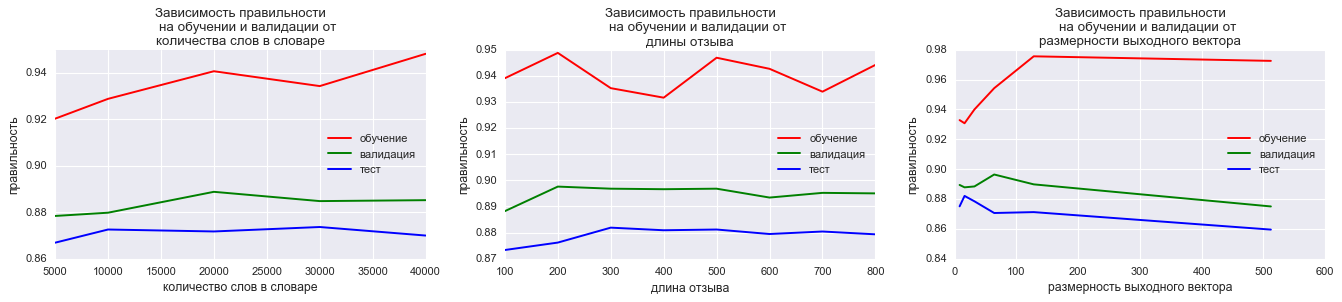

In [499]:
plt.style.use('seaborn')
x_labels_names = ['количество слов в словаре', 'длина отзыва', 'размерность выходного вектора']
title_labels_names = ['количества слов в словаре', 'длины отзыва', 'размерности выходного вектора']
fig, ax = plt.subplots(1, 3, figsize=(17, 4));
index = 0
for axis in ax:
    axis.plot(best_log_param[current_param_names[index]][3], 
              best_log_param[current_param_names[index]][0],
              'r', label='обучение')
    axis.plot(best_log_param[current_param_names[index]][3],
              best_log_param[current_param_names[index]][1], 
              'g', label='валидация')
    axis.plot(best_log_param[current_param_names[index]][3],
              best_log_param[current_param_names[index]][2], 
              'b', label='тест')
    axis.set_xlabel(x_labels_names[index])
    axis.set_ylabel('правильность')
    axis.set_title("Зависимость правильности\n\
    на обучении и валидации от\n{}".format(title_labels_names[index]))
    axis.legend(loc='best')
    index = index + 1
fig.tight_layout()

Посмотрим какой параметр в среднем больше влияет на модель

In [561]:
res = []
res_full = []
result = {}
for x in range(len(best_log_param)):
    for y in best_log_param[current_param_names[x]]:
        tmp = []
        for z in y:
            tmp.append(z)
        res.append(tmp)
        
index = 0
for f in [Enumerable(res).take(5).to_list(), 
          Enumerable(res).skip(5).take(5).to_list(), 
          Enumerable(res).skip(10).take(5).to_list()]:
    tmp_par = []
    for d in f:
        tmp_par.append(np.mean(d))
    result[current_param_names[index]] = tmp_par
    index = index + 1
main_df = pd.DataFrame(result, index=['обучающая','валидационныая', 'тестовая', 'параметры', 'количество'])
main_df.columns=['размер словаря', 'длина отзыва', 'размер выходного вектора']
main_df['выборка'] = main_df.index
display(main_df.iloc[[0,1,2,4]])

размер словаря,длина отзыва,размер выходного вектора,выборка
0.9344999999999999,0.9403312500000001,0.951,обучающая
0.8834000000000002,0.89495,0.8877999999999999,валидационныая
0.870952,0.87907,0.8728066666666665,тестовая
5.0,4.75,3.0,количество


Можно заметить, что наибольшее влияние на модель на тестовой выблоке и валидационной оказывает длина отзыва, но это так же стльно увеличивает переобучение модели. Наиболее полезный результат можно увидеть при изменении параметра: размер словаря, где наблюдается наименьший эффект переобучения А так же он в среднем наступает гораздо позже, только на 5 эпохе, это говорит о том, что модель в принципе обучается лучше и больше устойчива. Но в целом все варианты переобучаются. Стоит увеличить сложность модели, и посмотреть результат

Лучшие параметры

In [563]:
pd.Series(best_params)

max_features_params        20000
max_vocab                    200
output_vector_dimension       64
dtype: int64

Сделаем модель с лучшими параметрами

Подготовим параметры

In [589]:
max_features = 20000
maxlen = 200
output_vector_dimension = 64

Подготовим данные

In [590]:
x_train, x_test, y_train, y_test = prepare_data_set(train_df, test_df, 'review_vec', 'estimate')
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen)

Обучим модель

In [596]:
%%time
model_001, hstory_001 = model_001(max_features=max_features, 
                                  vector_dim=output_vector_dimension, 
                                  maxlen=maxlen, x=x_train, y=y_train, verbose=1)
clear_output()

Wall time: 1min 10s


In [606]:
print("Правильность на обучающей выборке: {}\n\
Правильность на валидационной выборке: {}\n\
Правильность на тестовой выборке: {}".format(
    np.max(hstory_001.history['acc']), np.max(hstory_001.history['val_acc']), 
    model_001.evaluate(x_test, y_test, verbose=0)[1]))

Правильность на обучающей выборке: 0.9553
Правильность на валидационной выборке: 0.8908
Правильность на тестовой выборке: 0.8758


## 10. Создание новых признаков и описание этого процесса

Попробуем учучшить простую модель, так как размер словаря наиболее интересная фича, можно попробовать его сократить, сделаем сначала лемматизацию признаков и посмотрим как это повлияет на результат

**Лемматизация**

In [608]:
%%time
print('iter: 1/2')
train_df['rewiew_lemmatize'] = data_hlp.lemmatization(train_df['review'])
clear_output()
print('iter: 2/2')
test_df['rewiew_lemmatize'] = data_hlp.lemmatization(test_df['review'])
clear_output()

Wall time: 48.2 s


**Создадим словарь**

In [609]:
%%time
tarin_df_lemm_vocab_by_count, train_df_lemm_vocab_by_popular = data_hlp.create_vocab(train_df['rewiew_lemmatize'])
clear_output()

Wall time: 1.39 s


Словарь уменьшился

In [610]:
len(train_df_vocab_by_popular) - len(tarin_df_lemm_vocab_by_count)

7597

Слов в словаре стало меньше на 7597. Посмотрим, сможет ли это помочь модели

**Создание вектороного представления**

Подготовим параметры

In [628]:
max_features = 20000
maxlen = 200
output_vector_dimension = 64

Подготовим данные

In [629]:
#time
print("iter: 1/2")
train_df['review_lemm_vec'] = data_hlp.create_vectors(train_df['rewiew_lemmatize'], 
                                                      tarin_df_lemm_vocab_by_count, max_features)
clear_output()
print("iter: 1/2")
test_df['review_lemm_vec'] = data_hlp.create_vectors(test_df['rewiew_lemmatize'], 
                                                     tarin_df_lemm_vocab_by_count, max_features)
clear_output()

In [630]:
x_train_lemm, x_test_lemm, y_train_lemm, y_test_lemm = prepare_data_set(train_df, test_df, 'review_lemm_vec', 'estimate')
x_train_lemm = keras.preprocessing.sequence.pad_sequences(x_train_lemm, maxlen)
x_test_lemm = keras.preprocessing.sequence.pad_sequences(x_test_lemm, maxlen)

Обучим модель

In [631]:
%%time
model_001_lemm, hstory_001_lemm = model_001(max_features=max_features, 
                                  vector_dim=output_vector_dimension, 
                                  maxlen=maxlen, x=x_train_lemm, y=y_train_lemm, verbose=1)
clear_output()

Wall time: 46.2 s


In [646]:
print("Правильность на обучающей выборке: {}\n\
Правильность на валидационной выборке: {}\n\
Правильность на тестовой выборке: {}".format(
    hstory_001_lemm.history['acc'], hstory_001_lemm.history['val_acc'], 
    model_001_lemm.evaluate(x_test_lemm, y_test_lemm, verbose=0)[1]))

Правильность на обучающей выборке: [0.7646, 0.86445]
Правильность на валидационной выборке: [0.8452, 0.8376]
Правильность на тестовой выборке: 0.84124


Лемматизация не помогла, правильность работы алгоритма снизилась. Судя по всему разные формы слов имеют некую силу в определении тональности реценизии. И лемматизация эту нотку притупляет. Гипотеза об улучшении прогнозной силы с пременением лемматизации в данном случае не подтвердилась

В итоге мы остановились на том, что модель слишком проста, рано переобучается. Необходимо повысить сложность модели. Попробуем обучить Word2Vec

**Обучение Word2Vec**

In [21]:
np.random.seed(18)

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [23]:
maxlen = 100 # Длина отзыва
training_samples = 200 # Количество выборок
validation_samples = 10000 # Проверка на выборке из 10000 образцов
max_words = 10000 # Рассмотрение только 10 000 самых используемых слов
embedding_dim = 300

In [7]:
train_df_frac = train_df.sample(frac=1)
test_df_frac = test_df.sample(frac=1)

In [8]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df_frac['review'])

In [9]:
sequences_train = tokenizer.texts_to_sequences(train_df_frac['review'])
sequences_test = tokenizer.texts_to_sequences(test_df_frac['review'])

Сериализуем токенайзер, чтобы использовать в приложении

In [57]:
data_hlp.safe_to_file(tokenizer, 'tokenizer.pickle')

saving success!


In [56]:
tokenizer.texts_to_sequences(['hello  world'])

[[4469, 74]]

In [11]:
word_index = tokenizer.word_index

In [12]:
len(word_index)

74065

In [13]:
data_train = pad_sequences(sequences_train, maxlen=maxlen)
data_test = pad_sequences(sequences_test, maxlen=maxlen)
label_train = np.array(train_df_frac['estimate'])
label_test = np.array(test_df_frac['estimate'])

In [14]:
sentence_stream = [doc.split(" ") for doc in train_df_frac['review']]

In [16]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(size=300, window=7, min_count=10, workers=10)
model.build_vocab(sentence_stream)

In [17]:
model.train(sentence_stream, epochs=10, total_examples=model.corpus_count)

(27333137, 29880890)

Создадим словарь

In [25]:
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        try:
            embedding_vector = model.wv.get_vector(word)
        except:
            embedding_vector = 0
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Заморозим первый слой, чтобы он не обучался
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'])

callbacks_list = [
                    keras.callbacks.EarlyStopping(
                    monitor='val_acc',
                    patience=1)]

history = model.fit(data_train, label_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
                   callbacks=callbacks_list)
clear_output()

print("Правильность на обучающей выборке: {}\n\
Правильность на валидационной выборке: {}\n\
Правильность на тестовой выборке: {}".format(
history.history['acc'], history.history['val_acc'], 
model.evaluate(data_test, label_test, verbose=0)[1]))

Правильность на обучающей выборке: [0.7742, 0.8192, 0.833, 0.84145]
Правильность на валидационной выборке: [0.8046, 0.8132, 0.8346, 0.8208]
Правильность на тестовой выборке: 0.82964


Снизить переобучение удалось используя Word2Vec, но правильность модели заметно упала. Попробуем обучить такую-же есть, но не используя Word2Vec

In [40]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'])

callbacks_list = [
                    keras.callbacks.EarlyStopping(
                    monitor='val_acc',
                    patience=1)]

history = model.fit(data_train, label_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
                   callbacks=callbacks_list)
clear_output()

print("Правильность на обучающей выборке: {}\n\
Правильность на валидационной выборке: {}\n\
Правильность на тестовой выборке: {}".format(
history.history['acc'], history.history['val_acc'], 
model.evaluate(data_test, label_test, verbose=0)[1]))

Правильность на обучающей выборке: [0.77365, 0.88985, 0.9321]
Правильность на валидационной выборке: [0.8454, 0.857, 0.8372]
Правильность на тестовой выборке: 0.82536


Повысилось переобучение, а тестовая и валидационная выборка остались почти на том же уровне

In [43]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Заморозим первый слой, чтобы он не обучался
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc'])

callbacks_list = [
                    keras.callbacks.EarlyStopping(
                    monitor='val_acc',
                    patience=1)]

history = model.fit(data_train, label_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
                   callbacks=callbacks_list)
clear_output()

print("Правильность на обучающей выборке: {}\n\
Правильность на валидационной выборке: {}\n\
Правильность на тестовой выборке: {}".format(
history.history['acc'], history.history['val_acc'], 
model.evaluate(data_test, label_test, verbose=0)[1]))

Правильность на обучающей выборке: [0.83385, 0.8737]
Правильность на валидационной выборке: [0.8638, 0.8578]
Правильность на тестовой выборке: 0.86372


Лучшая модель которую удалось получить с помощью нейронных сетей, причем с импользованием Word2Vec, если конечно покрутить параметры у векторизатора а так же со слоями сети, то можно улучшить результат. В этой модели практически на всех трех выборках результаты рядом, модель наиболее устойчива. Сохраним ее

**Сохраним модель**

In [44]:
# serialize model to JSON
model_json = model.to_json()
with open("model_best_neuro.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_best_neuro.h5")
print("Saved model to disk")

Saved model to disk


**Загрузка модели**

In [ ]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

Попробуем традиционные модели мвшинного обучения и старый добрый Tf-idf векторайзер. Посмотрим, стоила ли игра свеч

**TF-IDF**

Опять перемешаем выборки

In [220]:
train_df_frac = train_df.sample(frac=1)
test_df_frac = test_df.sample(frac=1)

Обучим TF-IDF

In [223]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
transformed_features = tfidf.fit_transform(train_df_frac['review'])
test_transformed = tfidf.transform(test_df_frac['review'])
logreg = LogisticRegression()
param_grid = {'C': [1]}
gscv = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)
gscv.fit(transformed_features, train_df_frac['estimate'])
print("Правильность на обучающей выборке: {}\n\
Правильность на валидационной выборке: {}\n\
Правильность на тестовой выборке: {}".format(
    gscv.score(transformed_features, train_df_frac['estimate']),
    gscv.best_score_, 
    gscv.score(test_transformed, test_df_frac['estimate'])))

Правильность на обучающей выборке: 0.91768
Правильность на валидационной выборке: 0.88464
Правильность на тестовой выборке: 0.88456


## Выводы

В итоге мы видим, что без лишних телодвижений и сложных операций простая логистическая регрессия справилась с зедечей лучше чем нейронные сети. Конечно выводы делать рано, и все зависит от качества подбора параметров, и были испробованы только некоторые подходы и гипотрезы которые можно применить к данным. В данной задаче еще много чего можно поисследовать и улучшать модель можно до бесконечности. Но для первого подхода весьма неплохой результат.